## DistilBERT - Multi-label Classfication

Beginning with imports of necessary modules.

In [ ]:
import numpy as np
import pandas as pd 
from sklearn.metrics import(
    confusion_matrix, 
    accuracy_score, 
    classification_report,
    roc_auc_score, 
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os

In [ ]:
# uncomment when running on Google Colab:
# !pip install transformers

import time
import sys
import copy
import torch 
import numpy as np
import pyarrow as pa
import csv
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F

from scipy.sparse import *
from typing import Iterable, Tuple
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader
from transformers import DistilBertConfig,DistilBertTokenizer,DistilBertModel

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.5 MB/s eta 0:00:00
ERROR: Operation cancelled by user


For us to be able loading the weights file which consists all of the previous training details, we should import the Google Drive module. The file is there.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


Now, we will read the updated train dataset, and the original test dataset.

In [ ]:
#1st training:
train_ds = pd.read_csv('/content/drive/MyDrive/train_set.csv', sep=',', encoding= 'unicode_escape')
train_ds = train_ds[["id", "comment_text", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
test_ds = pd.read_csv('/content/drive/MyDrive/test.csv', delimiter=',', quoting=csv.QUOTE_ALL, encoding='utf-8', error_bad_lines=False)
test_labels_ds = pd.read_csv('/content/drive/MyDrive/test_labels.csv', delimiter=',', quoting=csv.QUOTE_ALL, encoding='utf-8')

#2nd training:
new_train_ds = pd.read_csv('/content/drive/MyDrive/dataset_042023.csv', sep=',', encoding= 'unicode_escape')
new_train_ds = new_train_ds[["id", "content", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

<ipython-input-5-50e41aa833dc>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_ds = pd.read_csv('/content/drive/MyDrive/test.csv', delimiter=',', quoting=csv.QUOTE_ALL, encoding='utf-8', error_bad_lines=False)


Let us make some cleaning & fixes for our test dataset.

In [ ]:
test_merged = test_ds.merge(test_labels_ds)
test_merged.drop(test_merged[test_merged['toxic'] == -1].index, inplace = True)

Now, we will make our train & test variables from the datasets we got.

In [ ]:
y_train = train_ds[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].astype(float)
X_train = train_ds['comment_text']
new_y_train = new_train_ds[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].astype(float)
new_X_train = new_train_ds['content']
X_test = test_merged['comment_text']
y_test = test_merged[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].astype(float)

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

new_X_train = new_X_train.values
new_y_train = new_y_train.values

In [ ]:
second_X_train, X_test, second_y_train, y_test = train_test_split(new_X_train, new_y_train, test_size=0.25, random_state=42)

In [ ]:
# For testing only
# print(second_X_train.shape)
# print(second_y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
# print(X_train.shape)
# print(y_train.shape)

We will build a function to calculate the accuracy of the model we're building.

In [ ]:
def accuracy_thresh(y_pred, y_true, thresh:float=0.4, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
    return np.mean(((y_pred>thresh).float()==y_true.float()).float().cpu().numpy(), axis=1).sum()
#Expected object of scalar type Bool but got scalar type Double for argument #2 'other'

Now, we will define our model setting & properties with a config module we've imported initially.

In [ ]:
config = DistilBertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,dropout=0.1,num_labels=6,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

Next step will be to define the class of our model, based on "DistilBERT".

In [ ]:
class DistilBertForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_labels = config.num_labels
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(config.hidden_size, config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.dropout = nn.Dropout(config.seq_classif_dropout)
        nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, input_ids=None, attention_mask=None, head_mask=None, labels=None):
        distilbert_output = self.distilbert(
                                            input_ids=input_ids,
                                            attention_mask=attention_mask,
                                            head_mask=head_mask
                                            )
        hidden_state = distilbert_output[0]                    
        pooled_output = hidden_state[:, 0]                   
        pooled_output = self.pre_classifier(pooled_output)   
        pooled_output = nn.ReLU()(pooled_output)             
        pooled_output = self.dropout(pooled_output)        
        logits = self.classifier(pooled_output) 
        return logits

We would like to define the maximum length of a sequence, and a tokenizer.

In [ ]:
max_seq_length = 256
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Now, we want to build a class which take care about the creation of the whole Dataset.

In [ ]:
class TextDataset(Dataset):
    def __init__(self,x,y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self,index):
        tokenized_comment = tokenizer.tokenize(self.x[index])
        if len(tokenized_comment) > max_seq_length:
            tokenized_comment = tokenized_comment[:max_seq_length]

        ids_review  = tokenizer.convert_tokens_to_ids(tokenized_comment)
        padding = [0] * (max_seq_length - len(ids_review))    
        ids_review += padding        

        assert len(ids_review) == max_seq_length
        ids_review = torch.tensor(ids_review)
        hcc = self.y[index] # toxic comment        
        list_of_labels = [torch.from_numpy(hcc)]
        
        return ids_review, list_of_labels[0]
    
    def __len__(self):
        return len(self.x)

Now, we woule like to test random index (in our case, we've choose index 6) and see the output.

In [ ]:
TextDataset(second_X_train, second_y_train).__getitem__(6)[1]

tensor([0., 0., 0., 0., 0., 0.], dtype=torch.float64)

We would like to define a dataloader method and some additional methods which related, like shuffle of the data in our dataset.

In [ ]:
def safe_shuffle(X: np.ndarray, y: np.ndarray) -> np.ndarray:
  xy_shuffled = shuffle(list(zip(X, y)))
  X_res = []
  y_res = []
  for xy in xy_shuffled:
    X_res.append(xy[0])
    y_res.append(xy[-1])
  return np.array(X_res), np.array(y_res)

def get_dataloaders_dict_shuffled(X_train: np.ndarray,
                                  X_test: np.ndarray, 
                                  y_train: np.ndarray, 
                                  y_test: np.ndarray,  
                                  batch_size: int = 32) -> Tuple[dict]:
  X_train, y_train = safe_shuffle(X_train, y_train)
  training_dataset = TextDataset(X_train, y_train)
  test_dataset = TextDataset(X_test,y_test)

  dataloaders_dict = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=False),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  }
  dataset_sizes = {
    'train': len(X_train),
    'val': len(X_test)
  }
  return dataloaders_dict, dataset_sizes

Now, after we've defined all the properties and objects of our desired model, we can define all the necessary variables, and load the model with it's current weights.

Let us define our model and initial it.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification(config)
model.to(device)
# 1st training:
#model.load_state_dict(torch.load('/content/drive/MyDrive/distilbert_model_weights.pth'))
# 2nd training:
model.load_state_dict(torch.load('/content/drive/MyDrive/distilbert_model_weights_ver4.pth'))

print(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


For us to train our model, we should build a comfortable training function which will consist all the methods the model needs for optimal training.

In [ ]:
# Test
dataloaders_dict, dataset_sizes = get_dataloaders_dict_shuffled(
    second_X_train, X_test, second_y_train, y_test
)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=4):
    model.train()
    since = time.time()
    print('starting')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100
    
    train_total_loss = []
    train_micro_roc_auc_acc = []
    test_total_loss = []
    test_micro_roc_auc_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        dataloaders_dict, dataset_sizes = get_dataloaders_dict_shuffled(
            X_train, X_test, y_train, y_test
        )

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            beta_score_accuracy = 0.0            
            micro_roc_auc_acc = 0.0
                        
            # Iterate over data.
            for inputs, hcc in dataloaders_dict[phase]:    
                inputs = inputs.to(device) 
                hcc = hcc.to(device)
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs,hcc.float())
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                micro_roc_auc_acc +=  accuracy_thresh(outputs.view(-1,6),hcc.view(-1,6))

            epoch_loss = running_loss / dataset_sizes[phase]            
            epoch_micro_roc_acc = micro_roc_auc_acc / dataset_sizes[phase]

            print('{} total loss: {:.4f} '.format(phase,epoch_loss ))
            print('{} micro_roc_auc_acc: {:.4f}'.format( phase, epoch_micro_roc_acc))
            if phase == 'train':
              train_total_loss.append(epoch_loss)
              train_micro_roc_auc_acc.append(epoch_micro_roc_acc)
            else:
              test_total_loss.append(epoch_loss)
              test_micro_roc_auc_acc.append(epoch_micro_roc_acc)

            if phase == 'val' and epoch_loss < best_loss:
                print('saving with loss of {}'.format(epoch_loss),
                      'improved over previous {}'.format(best_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'distilbert_model_weights_ver2.pth')
         
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(float(best_loss)))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_total_loss, train_micro_roc_auc_acc, test_total_loss, test_micro_roc_auc_acc, best_loss
print('done')

done


Before we're starting our training, we'll define some last parameters for the sake of an optimal training. 

In [ ]:
lrlast = .001
lrmain = 3e-5
optim1 = torch.optim.Adam(model.parameters(),lrmain)
optimizer_ft = optim1
criterion = nn.BCEWithLogitsLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
NUM_EPOCHS = 6

Let us start the training of the model we've built.

In [ ]:
model_ft1, train_total_loss, train_micro_roc_auc_acc, test_total_loss, test_micro_roc_auc_acc, best_loss = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

starting
Epoch 1/6
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train total loss: 0.2186 
train micro_roc_auc_acc: 0.9073
val total loss: 0.1971 
val micro_roc_auc_acc: 0.9162
saving with loss of 0.19708213202148 improved over previous 100

Epoch 2/6
----------
train total loss: 0.1657 
train micro_roc_auc_acc: 0.9298
val total loss: 0.1906 
val micro_roc_auc_acc: 0.9188
saving with loss of 0.19063341315184162 improved over previous 0.19708213202148

Epoch 3/6
----------
train total loss: 0.1099 
train micro_roc_auc_acc: 0.9557
val total loss: 0.2056 
val micro_roc_auc_acc: 0.9199

Epoch 4/6
----------
train total loss: 0.0986 
train micro_roc_auc_acc: 0.9598
val total loss: 0.2091 
val micro_roc_auc_acc: 0.9218

Epoch 5/6
----------
train total loss: 0.0907 
train micro_roc_auc_acc: 0.9638
val total loss: 0.2183 
val micro_roc_auc_acc: 0.9230

Epoch 6/6
----------
train total loss: 0.0841 
train micro_roc_auc_acc: 0.9665
val total loss: 0.2172 
val micro_roc_auc_acc: 0.9230

Training complete in 45m 31s
Best val Acc: 0.190633


After the model has finished its training, we want to test the results. We would like to make some predictions and see how the model acts.

First, we would like to prepare our test dataset to fill in the model properly.

In [ ]:
test_dataset = TextDataset(X_test,y_test)
prediction_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

We will define a function which will do all the predict method.

In [ ]:
def preds(model,test_loader):
    predictions = []
    for inputs, sentiment in test_loader:
        inputs = inputs.to(device) 
        sentiment = sentiment.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            predictions.append(outputs.cpu().detach().numpy().tolist())
    return predictions

Now, we can use our model on the test set and see if its good.

At that time, when we got exactly the test data set we want, we will adjust it to the methods of our model and test it.

In [ ]:
predictions = preds(model=model,test_loader=prediction_dataloader)
predictions = np.array(predictions)[:,0]
y_label = np.round(predictions)

In [ ]:
final_y_pred = np.array(y_label)
final_y_pred.shape

(5992, 6)

Now, we would like to check the accuracy of the model we've built.

In [ ]:
print("\nThe accuracy of the model:")
acc_model = np.round(accuracy_score(np.argmax(y_test, axis=1), np.argmax(final_y_pred, axis=1)), 4)
print(acc_model)
y_test_conf_matr = np.argmax(y_test, axis=1)
y_label_conf_matr = np.argmax(final_y_pred, axis=1)


The accuracy of the model:
0.9302


For be more specified with the model's evaluation, let us show a Confusion Matrix for each label

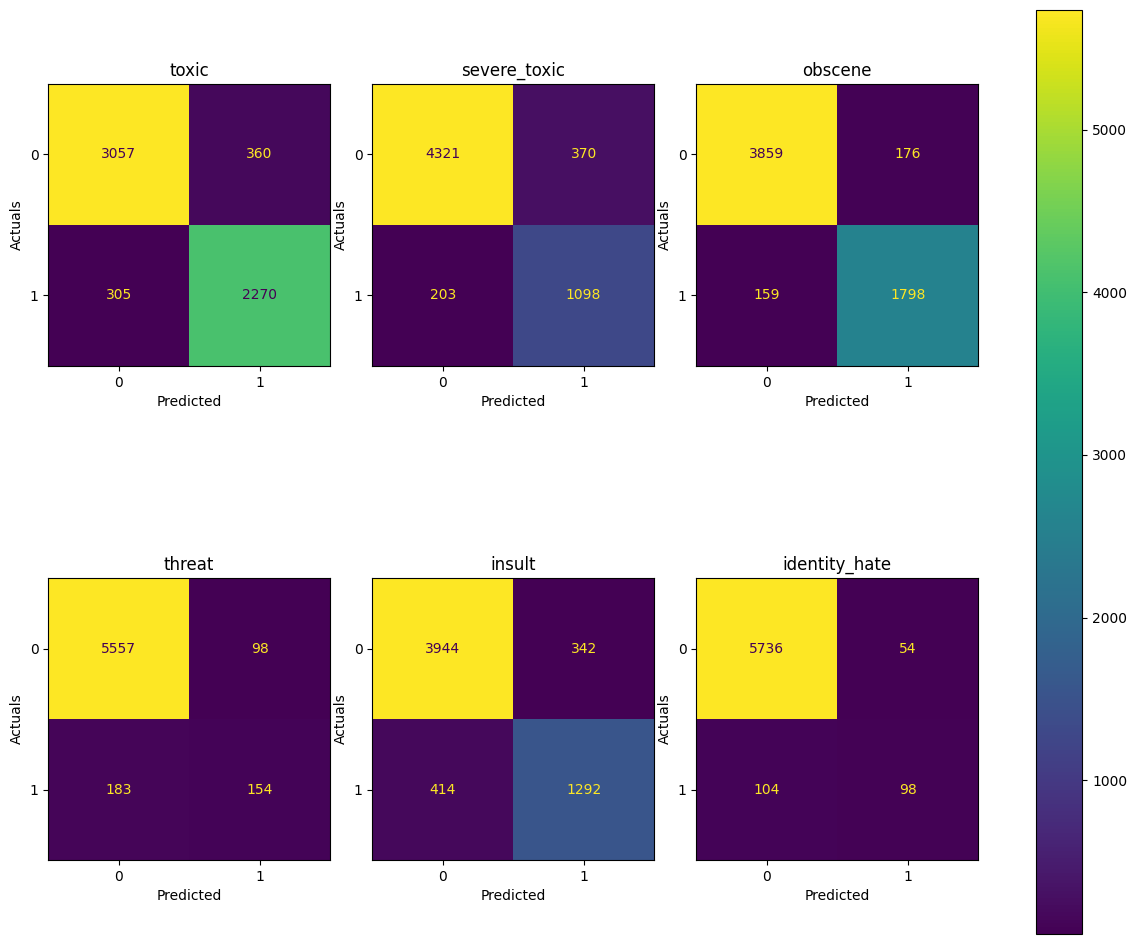

In [ ]:
f, axes = plt.subplots(2, 3, figsize=(15, 12))
axes = axes.ravel()
labels = {"toxic": 0, "severe_toxic": 1, "obscene": 2, "threat": 3, "insult": 4, "identity_hate": 5}

for label in labels:
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, labels[label]],
                                                   final_y_pred[:, labels[label]]))
    disp.plot(ax=axes[labels[label]], values_format='.4g')
    disp.ax_.set_title(f'{label}')
    if labels[label]<10:
        disp.ax_.set_xlabel('Predicted')
        disp.ax_.set_ylabel('Actuals')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.15, hspace=0.15)
f.colorbar(disp.im_, ax=axes)
plt.show()

In addition to the above, let us plot a Classification Report table

In [ ]:
target_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
print(classification_report(y_test, final_y_pred, target_names=target_names))

               precision    recall  f1-score   support

        toxic       0.86      0.88      0.87      2575
 severe_toxic       0.75      0.84      0.79      1301
      obscene       0.91      0.92      0.91      1957
       threat       0.61      0.46      0.52       337
       insult       0.79      0.76      0.77      1706
identity_hate       0.64      0.49      0.55       202

    micro avg       0.83      0.83      0.83      8078
    macro avg       0.76      0.72      0.74      8078
 weighted avg       0.82      0.83      0.83      8078
  samples avg       0.38      0.39      0.37      8078



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We will show a plot of ROC-AUC Accuracy as well.

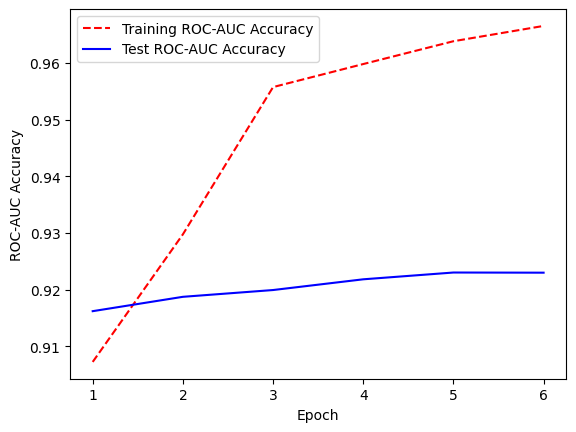

In [ ]:
epoch_count = range(1, len(train_micro_roc_auc_acc)+1)

# Visualize ROC-AUC Accuracy history
plt.plot(epoch_count, train_micro_roc_auc_acc, 'r--')
plt.plot(epoch_count, test_micro_roc_auc_acc, 'b-')
plt.legend(['Training ROC-AUC Accuracy', 'Test ROC-AUC Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC Accuracy')
plt.show()